# Peer-graded Assignment: Прогнозирование уровня средней заработной платы в России

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

import itertools

%pylab inline

def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

Populating the interactive namespace from numpy and matplotlib


В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [2]:
data = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=True, dayfirst=True)
data.rename(columns={'WAG_C_M': 'wage'}, inplace=True)
data.shape

(284, 1)

In [3]:
data.head()

,wage
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


### 1. Визуальный анализ ряда

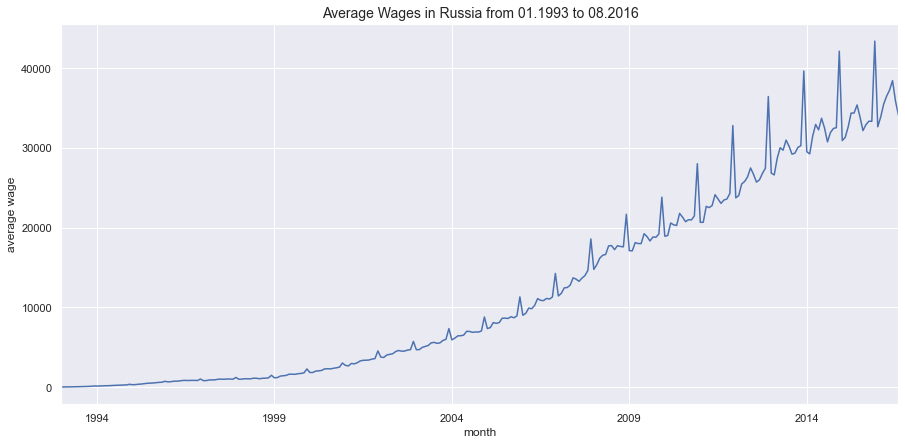

In [4]:
plt.figure(figsize=(15,7))
data.wage.plot()
plt.title('Average Wages in Russia from 01.1993 to 08.2016', fontsize=14)
plt.ylabel('average wage')
plt.show()

Проверим гипотезу о стационарности ряда критерием Дики-Фуллера и сделаем STL-декомпозицию ряда:

$H_0$: ряд нестационарен

$H_1$: ряд стационарен

In [5]:
print(f"Dickey-Fuller test: p-value = {sm.tsa.stattools.adfuller(data.wage)[1]:.4f}")

Dickey-Fuller test: p-value = 0.9918


Нулевая гипотеза $H_0$ не отвергается, p-value > $\alpha=0.05$, ряд нестационарен

<Figure size 1080x720 with 0 Axes>

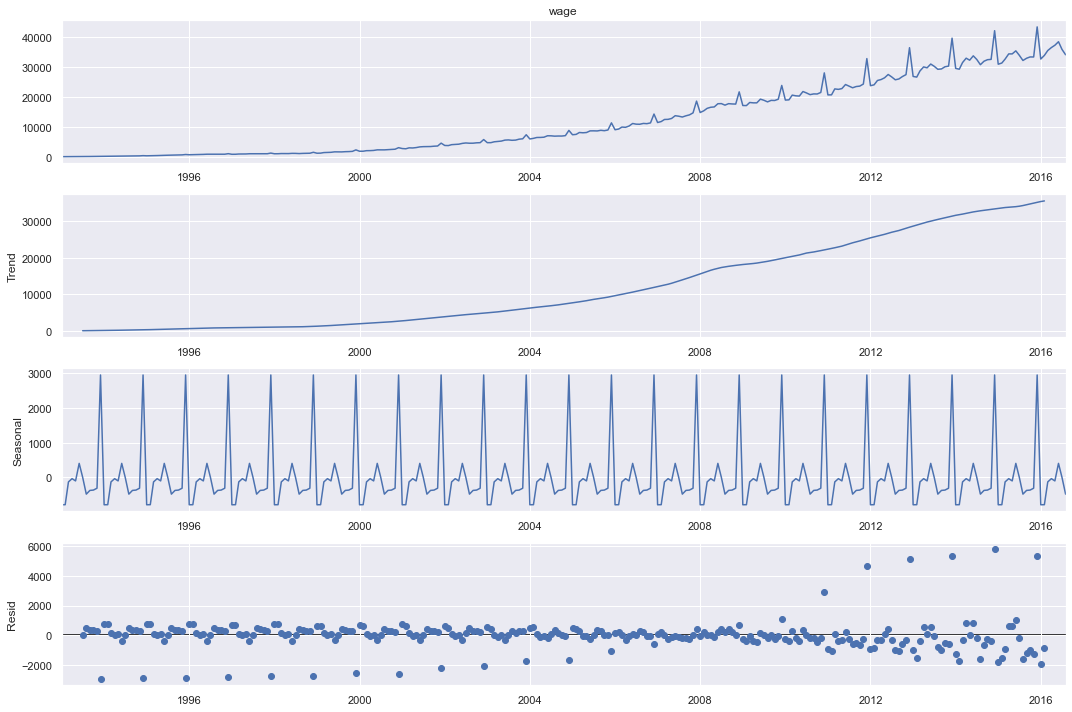

In [6]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage).plot()
plt.show()

<b>Вывод</b>: Из временного ряда и его STL-декомпозиции видно, что ряд нестационарен; обладает явным восходящим трендом; присутствует сильно выраженная годовая сезонность; у ряда нестационарная дисперсия (размах значений в начале ряда и в конце сильно отличается)

### 2. Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Optimal parameter of Box-Cox transformation: lambda=0.2632017541844584
Dickey-Fuller test: p-value = 0.6969


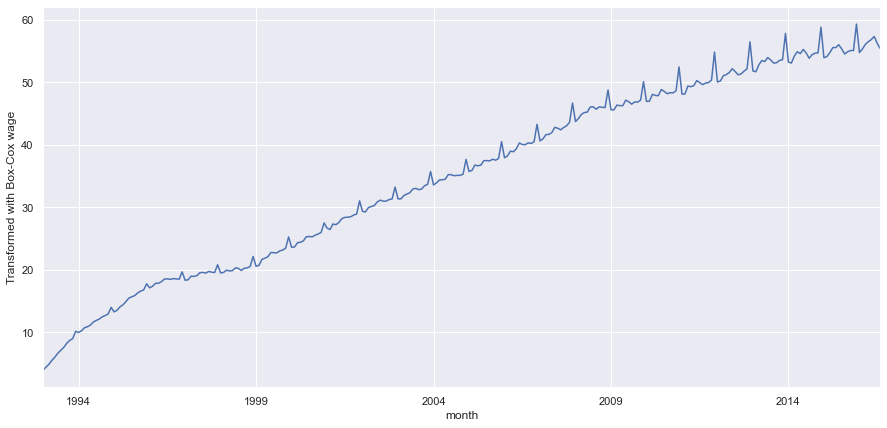

In [7]:
data['wage_box'], lmbda = stats.boxcox(data.wage)
plt.figure(figsize(15,7))
data.wage_box.plot()
plt.ylabel('Transformed with Box-Cox wage')
print(f'Optimal parameter of Box-Cox transformation: lambda={lmbda}')
print(f'Dickey-Fuller test: p-value = {sm.tsa.stattools.adfuller(data.wage_box)[1]:.4f}')

<b>Вывод</b>: Нулевая гипотеза $H_0$ не отвергается, p-value > $\alpha=0.05$, ряд нестационарен.

После преобразования Бокса-Кокса дисперсия значений временного ряда была стабилизирована, но хоть уровень достигаемой значимости критерия Дики-Фуллера уменьшился (0.69 против 0.99), ряд по-прежнему нестационарен. Необходимо произвести дифференцирование ряда.

### 3. Стационарность и дифференцирование ряда

Для начала произведем сезонное дифференцирование, сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность критерием Дики-Фуллера:

<Figure size 1080x720 with 0 Axes>

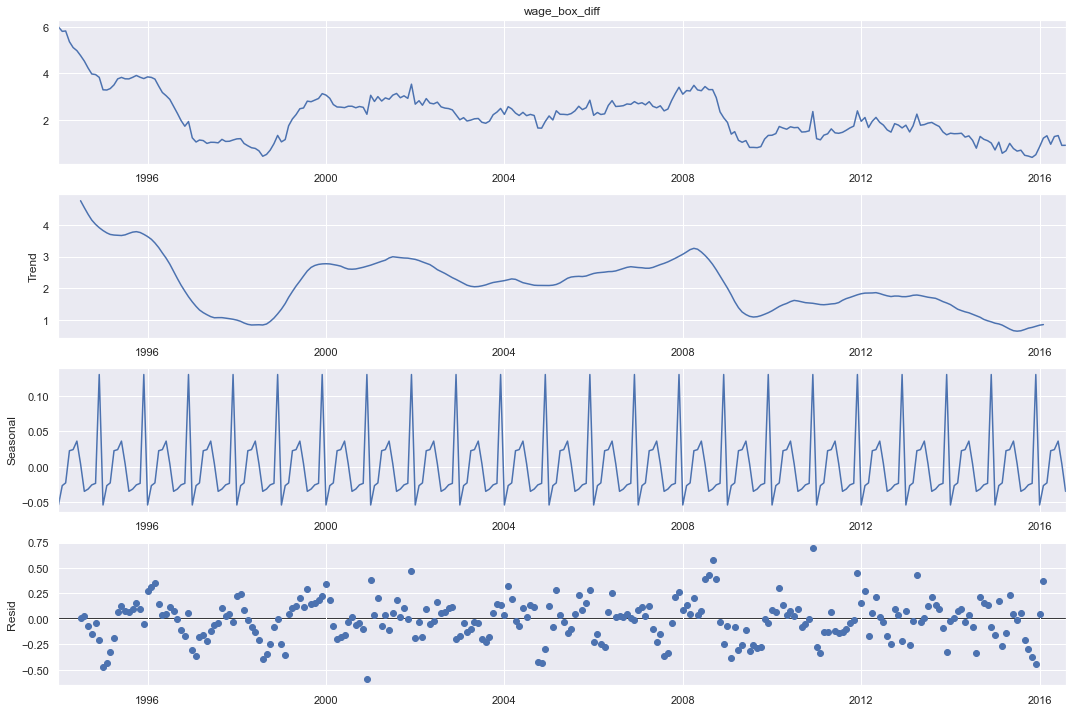

Dickey-Fuller test: p-value = 0.0147


In [8]:
data['wage_box_diff'] = data.wage_box - data.wage_box.shift(12)

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage_box_diff[12:]).plot()
plt.show()

print(f"Dickey-Fuller test: p-value = {sm.tsa.stattools.adfuller(data.wage_box_diff[12:])[1]:.4f}")

Полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

<Figure size 1080x720 with 0 Axes>

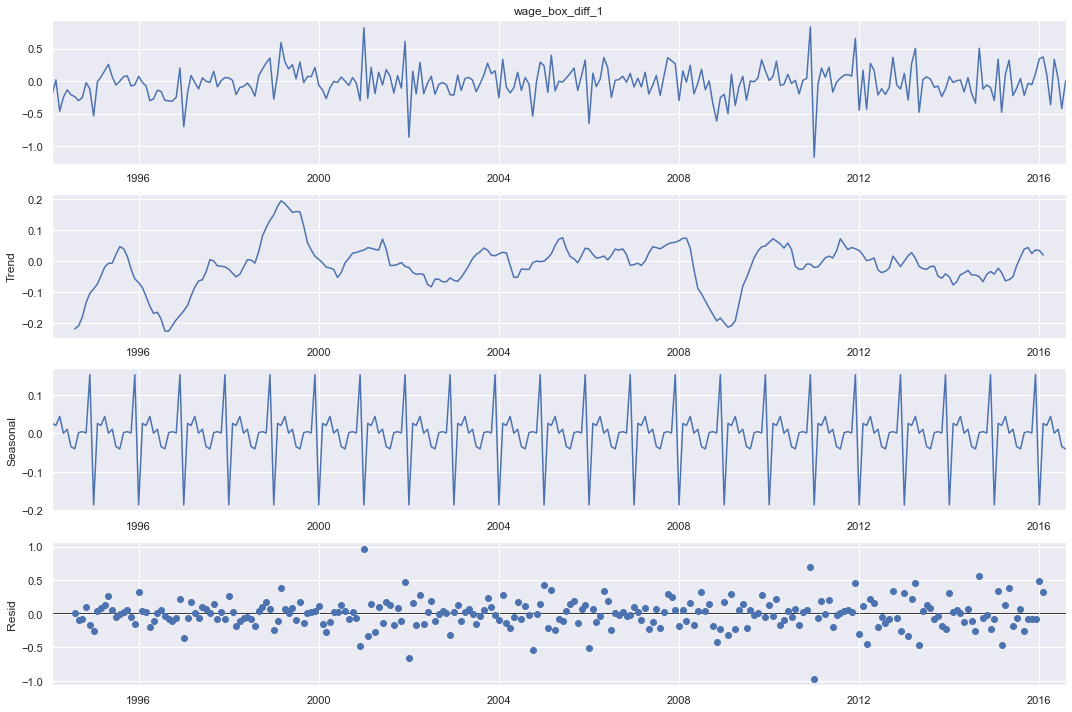

Dickey-Fuller test: p-value = 0.0000


In [9]:
data['wage_box_diff_1'] = data.wage_box_diff - data.wage_box_diff.shift(1)

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage_box_diff_1[13:]).plot()
plt.show()

print(f"Dickey-Fuller test: p-value = {sm.tsa.stattools.adfuller(data.wage_box_diff_1[13:])[1]:.4f}")

<b>Вывод</b>: Гипотеза нестационарности отвергается на уровне значимости $\alpha=0.05$, и визуально временной ряд выглядит лучше — тренда больше нет.

### 4. Выбор начальных приближений для параметров p, q, P, Q модели ARIMA

Посмотрим на коррелограммы ACF и PACF (автокорреляции и частичной автокорреляции соответственно) полученного продиференцированного временного ряда:

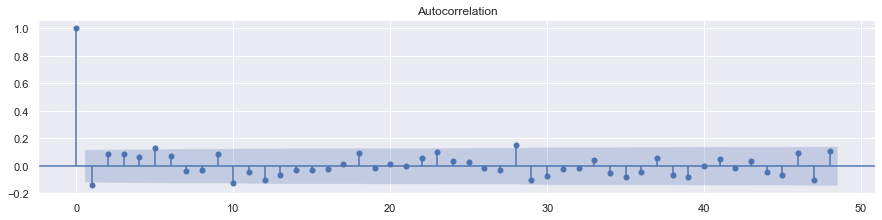

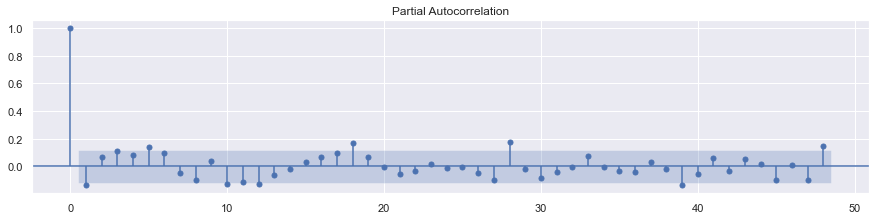

In [10]:
plt.figure(figsize(15,7))
ax = plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(data.wage_box_diff_1[13:].values.squeeze(), lags=48, ax=ax)
plt.show()
ax = plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data.wage_box_diff_1[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

Выберем начальные приближения для параметров по коррелограммам и эвристическим правилам.

Начальные приближения: Q=0, q=1, P=1, p=1

In [11]:
ps = range(0, 2)
qs = range(0, 2)
Ps = range(0, 2)
Qs = range(0, 1)
d = 1
D = 1

In [12]:
parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(parameters_list)
print(len(parameters_list))

[(0, 0, 0, 0), (0, 0, 1, 0), (0, 1, 0, 0), (0, 1, 1, 0), (1, 0, 0, 0), (1, 0, 1, 0), (1, 1, 0, 0), (1, 1, 1, 0)]
8


### 5. Обучение и сравнение моделей ARIMA

Обучим все 8 моделей с различными параметрами (перебор по сетке) и выберем лучшую модель ARIMA для нашего набора данных по информационному критерию Акаике:

In [13]:
%%time

results = []
best_aic = float('inf')

for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(data.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except Exception:
        print('wrong parameters:', param)
        continue
        
    aic = model.aic

    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

CPU times: user 3.88 s, sys: 2.26 s, total: 6.14 s
Wall time: 1.9 s


In [14]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
5  (1, 0, 1, 0)  0.340521
3  (0, 1, 1, 0)  1.170768
7  (1, 1, 1, 0)  2.021912
4  (1, 0, 0, 0)  2.625709
2  (0, 1, 0, 0)  3.369832


Выбираем лучшую модель по критерию Акаике AIC (чем меньше, тем лучше модель). Модель №5 с AIC=0.34 лучше остальных.

#### Лучшая модель по критерию AIC:

In [15]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           wage_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Sat, 14 Nov 2020   AIC                              0.341
Time:                                    18:02:18   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

### 6. Анализ остатков построенной модели

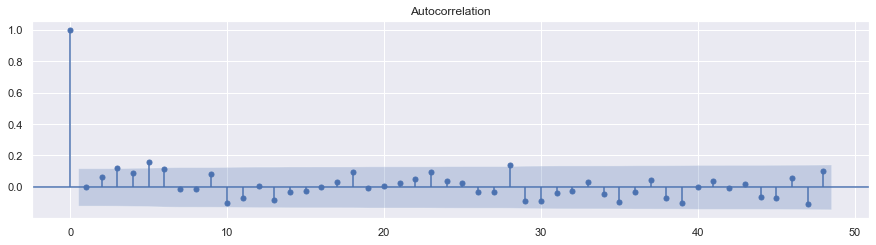

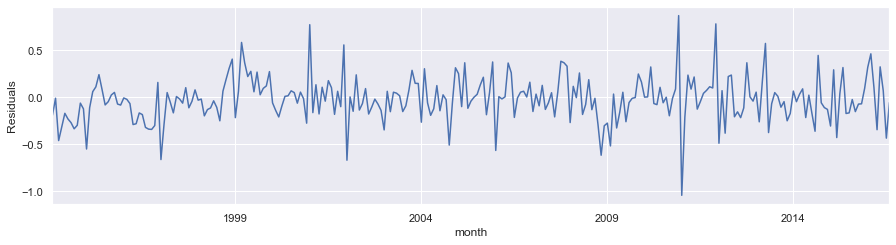

Student test (residuals unbiased): p-value = 0.0908
Dickey-Fuller test (residuals unstationarity): p-value = 0.0000


In [16]:
plt.figure(figsize(15,8))
plt.tight_layout()

ax = plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

plt.subplot(2,1,2)
best_model.resid[13:].plot()
plt.ylabel('Residuals')
plt.show()

print(f"Student test (residuals unbiased): p-value = {stats.ttest_1samp(best_model.resid[13:], 0)[1]:.4f}")
print(f"Dickey-Fuller test (residuals unstationarity): p-value = {sm.tsa.stattools.adfuller(best_model.resid[13:])[1]:.4f}")

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:


### 7. Прогнозирование с помощью финальной модели

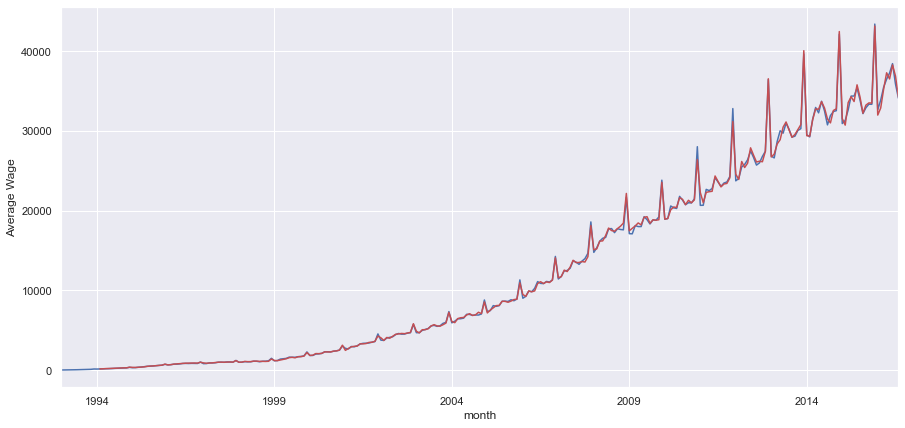

In [17]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)

plt.figure(figsize(15,7))
data.wage.plot()
data.model[13:].plot(color='r')

plt.ylabel('Average Wage')
plt.show()

Модель ARIMA практически идеально описывает данные на тестовой выборке. Теперь сделаем прогноз заработных плат на два года вперед начиная с сентября 2016

#### Прогноз модели на 2 года вперед:

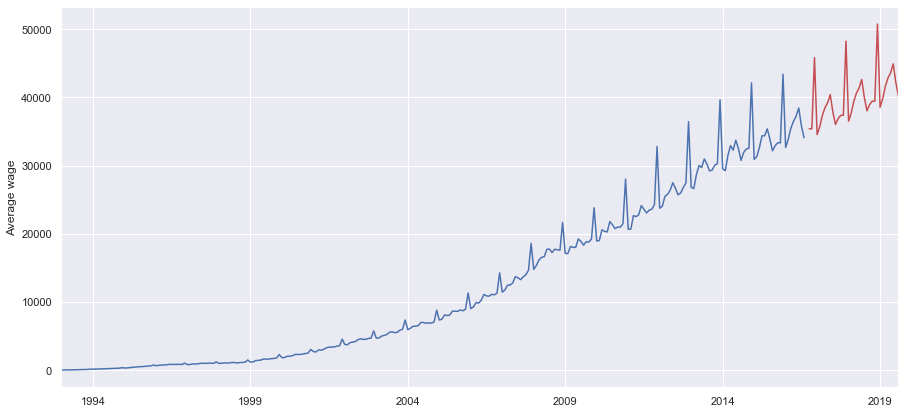

In [18]:
wage_2 = data[['wage']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]

future = pd.DataFrame(index=date_list, columns= wage_2.columns)

wage_2 = pd.concat([wage_2, future])
wage_2['forecast'] = invboxcox(best_model.predict(start=285, end=321), lmbda)

plt.figure(figsize(15,7))
wage_2.wage.plot()
wage_2.forecast.plot(color='r')
plt.ylabel('Average wage')
plt.show()

Полученный с помощью модели прогноз вписывается в общий тренд, хорошо описывает сезонность значений и дисперсию значений ряда.

### Review criteria

#### Придерживайтесь стандартного алгоритма построения прогноза:

- Визуальный анализ ряда
- Стабилизация дисперсии (при необходимости)
- Выбор порядка дифференцирования
- Выбор начальных приближений для p, q, P, Q
- Обучение и сравнение моделей-кандидатов, выбор победителя
- Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Q.
- Прогнозирование с помощью финальной модели.